In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LINK&tsym=XRP&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [3]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-02-07,0.5769,0.5186,0.5542,1818965.52,966783.65,0.5315
2018-02-08,0.5605,0.4798,0.5315,112683.24,58222.02,0.5167
2018-02-09,0.4888,0.4566,0.5167,734369.05,345832.52,0.4709
2018-02-10,0.4444,0.3990,0.4709,1724349.62,697174.85,0.4043
2018-02-11,0.4492,0.3974,0.4059,941542.59,408240.76,0.4336
...,...,...,...,...,...,...
2020-10-30,47.2100,45.8200,46.5600,457537.24,21235998.48,46.4100
2020-10-31,47.1400,46.2400,46.4100,341382.80,16006105.47,46.8900
2020-11-01,48.4500,47.3400,46.8900,330384.37,15913058.80,48.1700


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

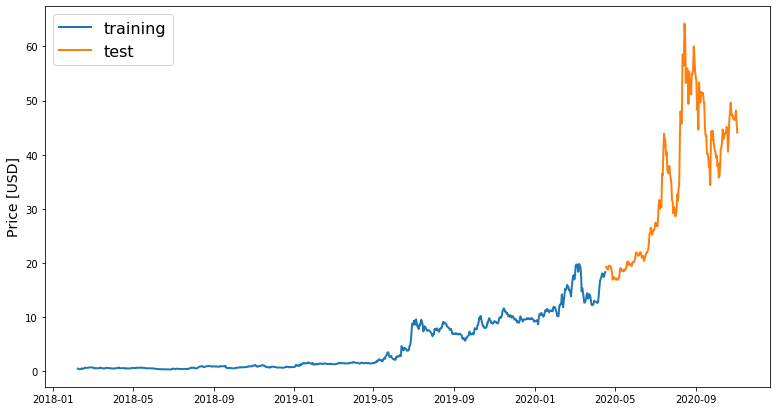

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)


Epoch 1/20
796/796 [==============================] - 0s 570us/step - loss: 0.0164
Epoch 2/20
796/796 [==============================] - 0s 165us/step - loss: 0.0114
Epoch 3/20
796/796 [==============================] - 0s 141us/step - loss: 0.0101
Epoch 4/20
796/796 [==============================] - 0s 128us/step - loss: 0.0086
Epoch 5/20
796/796 [==============================] - 0s 133us/step - loss: 0.0085
Epoch 6/20
796/796 [==============================] - 0s 143us/step - loss: 0.0083
Epoch 7/20
796/796 [==============================] - 0s 133us/step - loss: 0.0080
Epoch 8/20
796/796 [==============================] - 0s 131us/step - loss: 0.0075
Epoch 9/20
796/796 [==============================] - 0s 130us/step - loss: 0.0067
Epoch 10/20
796/796 [==============================] - 0s 132us/step - loss: 0.0062
Epoch 11/20
796/796 [==============================] - 0s 137us/step - loss: 0.0070
Epoch 12/20
796/796 [==============================] - 0s 139us/step - loss: 0.0063


In [16]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04233056418701401

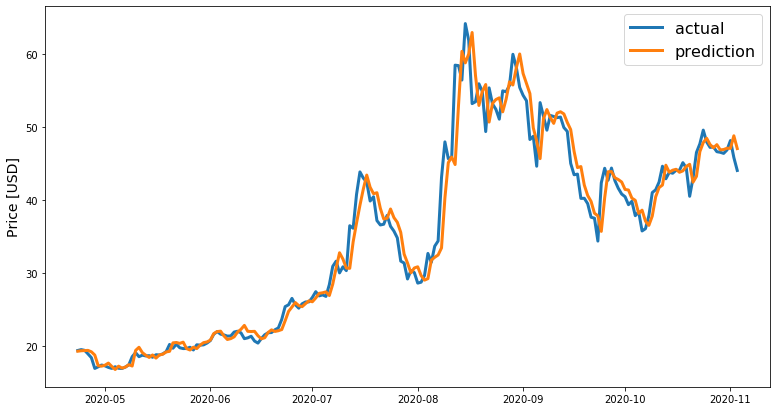

In [17]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)